# Imports (same as the notebook y'all shared)

In [1]:

import scipy
from scipy.signal import windows, welch
from scipy.signal.windows import dpss
from scipy.fft import fft, fftfreq
import numpy as np
import math
import matplotlib.pyplot as plt
from spectral_decomposition import spectrum
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import seaborn as sns

## Below the generate_data function is redundant but kept it here just to demonstrate

In [2]:
def generate_data(random_state = 42):
    data = spectrum(
        sampling_rate=1000,
        duration=30,
        aperiodic_exponent=2.0,
        aperiodic_offset=2.0,
        knee=200,
        peaks=[{'freq':12, 'amplitude': 1.0, 'sigma': 2.0}],
        average_firing_rate=0.0,
        random_state=random_state,
        direct_estimate=True,
    )
    return data

data = generate_data()
data_td = data.time_domain.combined_signal
data_fd = data.frequency_domain

## On long time scales, all estimators converge to the same estimate with lower bias (and lower variance for multitaper)

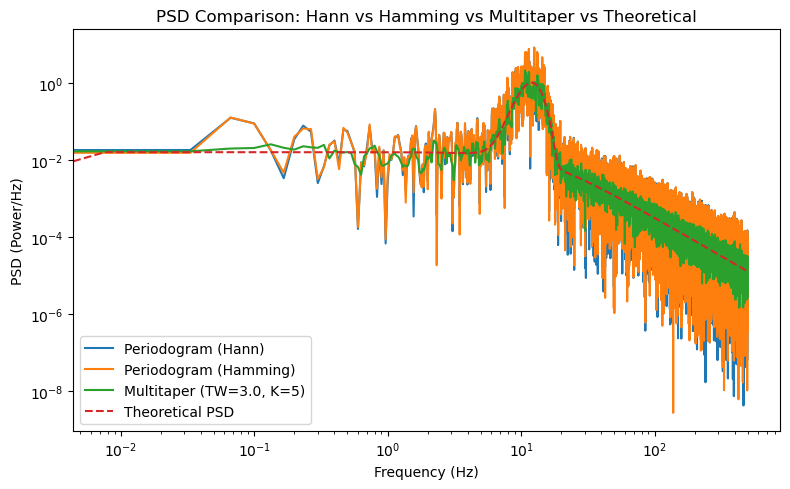

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from spectral_connectivity import Multitaper, Connectivity
from spectral_decomposition import spectrum

# ———— 1) Simulate / load your data ——————
fs       = 1000.0   # Hz
duration = 30     # seconds

res = spectrum(
    sampling_rate      = fs,
    duration           = duration,
    aperiodic_exponent = 2.0,
    aperiodic_offset   = 0.5,
    knee               = 200.0,
    peaks              = [{'freq':12,'amplitude':1.0,'sigma':2.0}],
    average_firing_rate= 0.0,
    random_state       = 42,
    direct_estimate    = True,    # empirical multitaper
)
signal = res.time_domain.combined_signal
N      = len(signal)

# ———— 2) Single‐taper periodograms via SciPy ——————
# Full-length window, no overlap, full NFFT:
freqs_hann, psd_hann = periodogram(
    x       = signal,
    fs      = fs,
    window  = 'hann',
    nfft    = N,
    scaling = 'density'
)
freqs_hamm, psd_hamm = periodogram(
    x       = signal,
    fs      = fs,
    window  = 'hamming',
    nfft    = N,
    scaling = 'density'
)

# ———— 3) Multitaper PSD via spectral_connectivity ——————
TW = 3.0
K  = int(2*TW - 1)
mt = Multitaper(
    time_series                = signal,
    sampling_frequency         = fs,
    time_halfbandwidth_product = TW,
    n_tapers                   = K
)
conn      = Connectivity.from_multitaper(mt)
freqs_mt  = conn.frequencies
psd_mt    = conn.power().squeeze()

# ———— 4) Theoretical PSD (positive freqs only) ——————
res_th = spectrum(
    sampling_rate      = fs,
    duration           = duration,
    aperiodic_exponent = 2.0,
    aperiodic_offset   = 0.5,
    knee               = 200.0,
    peaks              = [{'freq':12,'amplitude':1.0,'sigma':2.0}],
    average_firing_rate= 0.0,
    direct_estimate    = False,
    random_state       = 42,
    plot               = False
)
freqs_th = res_th.frequency_domain.frequencies
psd_th   = res_th.frequency_domain.combined_spectrum
mask     = freqs_th >= 0
freqs_th = freqs_th[mask]
psd_th   = psd_th[mask]

# ———— 5) Plot everything ——————
plt.figure(figsize=(8,5))
plt.loglog(freqs_hann, psd_hann, label='Periodogram (Hann)')
plt.loglog(freqs_hamm, psd_hamm, label='Periodogram (Hamming)')
plt.loglog(freqs_mt,   psd_mt,   label=f'Multitaper (TW={TW}, K={K})')
plt.loglog(freqs_th,   psd_th,   '--', label='Theoretical PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (Power/Hz)')
plt.title('PSD Comparison: Hann vs Hamming vs Multitaper vs Theoretical')
plt.legend()
plt.tight_layout()
plt.show()


## Frequency by frequency comparison of bias

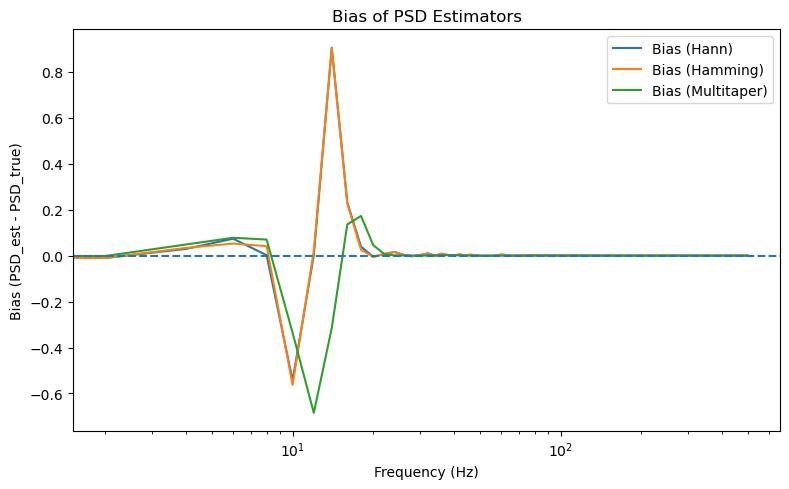

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from spectral_connectivity import Multitaper, Connectivity
from spectral_decomposition import spectrum

# ———— 1) Simulate / load your data ——————
fs       = 1000.0   # Hz
duration = 0.5      # seconds

res = spectrum(
    sampling_rate      = fs,
    duration           = duration,
    aperiodic_exponent = 2.0,
    aperiodic_offset   = 0.5,
    knee               = 200.0,
    peaks              = [{'freq':12,'amplitude':1.0,'sigma':2.0}],
    average_firing_rate= 0.0,
    random_state       = 42,
    direct_estimate    = True,    # empirical multitaper
)
signal = res.time_domain.combined_signal
N      = len(signal)

# ———— 2) Single‐taper periodograms via SciPy ——————
freqs_hann, psd_hann = periodogram(signal, fs=fs, window='hann',  nfft=N, scaling='density')
freqs_hamm, psd_hamm = periodogram(signal, fs=fs, window='hamming', nfft=N, scaling='density')

# ———— 3) Multitaper PSD via spectral_connectivity ——————
TW = 3.0
K  = int(2*TW - 1)
mt = Multitaper(
    time_series                = signal,
    sampling_frequency         = fs,
    time_halfbandwidth_product = TW,
    n_tapers                   = K
)
conn      = Connectivity.from_multitaper(mt)
freqs_mt  = conn.frequencies
psd_mt    = conn.power().squeeze()

# ———— 4) Theoretical PSD (positive freqs only) ——————
res_th = spectrum(
    sampling_rate      = fs,
    duration           = duration,
    aperiodic_exponent = 2.0,
    aperiodic_offset   = 0.5,
    knee               = 200.0,
    peaks              = [{'freq':12,'amplitude':1.0,'sigma':2.0}],
    average_firing_rate= 0.0,
    random_state       = 42,
    direct_estimate    = False,
    plot               = False
)
freqs_th = res_th.frequency_domain.frequencies
psd_th   = res_th.frequency_domain.combined_spectrum
mask     = freqs_th >= 0
freqs_th = freqs_th[mask]
psd_th   = psd_th[mask]

# ———— 5) Compute bias = PSD_est - PSD_true ——————
psd_th_hann = np.interp(freqs_hann, freqs_th, psd_th)
bias_hann   = psd_hann - psd_th_hann

psd_th_hamm = np.interp(freqs_hamm, freqs_th, psd_th)
bias_hamm   = psd_hamm - psd_th_hamm

psd_th_mt   = np.interp(freqs_mt, freqs_th, psd_th)
bias_mt     = psd_mt   - psd_th_mt

# ———— 6) Plot bias for each estimator ——————
plt.figure(figsize=(8,5))
plt.semilogx(freqs_hann, bias_hann, label='Bias (Hann)')
plt.semilogx(freqs_hamm, bias_hamm, label='Bias (Hamming)')
plt.semilogx(freqs_mt,   bias_mt,   label='Bias (Multitaper)')
plt.axhline(0, linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Bias (PSD_est - PSD_true)')
plt.title('Bias of PSD Estimators')
plt.legend()
plt.tight_layout()
plt.show()


## 50 runs (run more than this), demonstrate the dB scaling for how large it is

C:\Users\alice\AppData\Local\Temp\ipykernel_29100\966066182.py:34: RuntimeWarning: divide by zero encountered in log10
  P_th_db = 10 * np.log10(P_th)


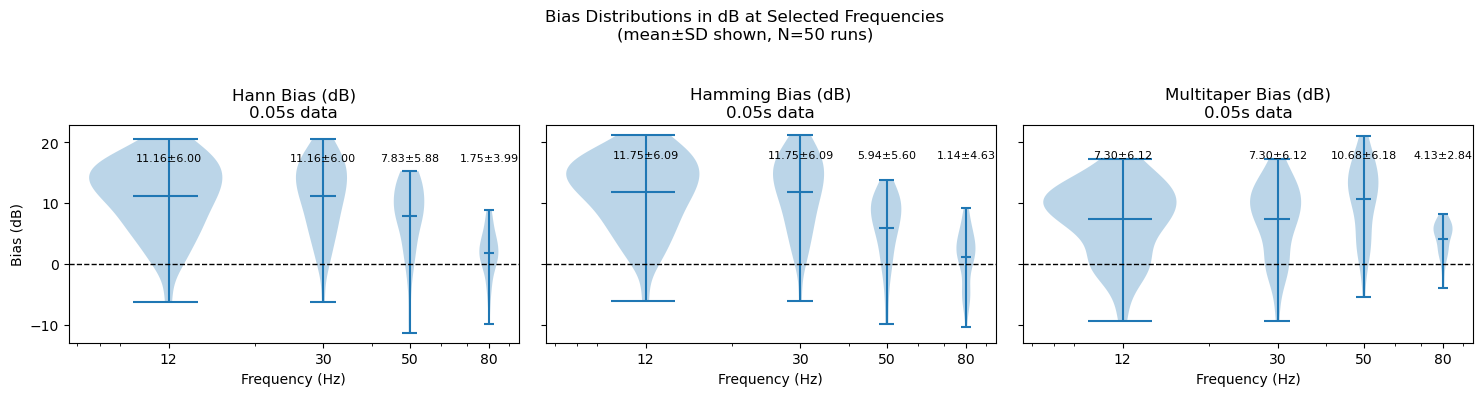

C:\Users\alice\AppData\Local\Temp\ipykernel_29100\966066182.py:34: RuntimeWarning: divide by zero encountered in log10
  P_th_db = 10 * np.log10(P_th)


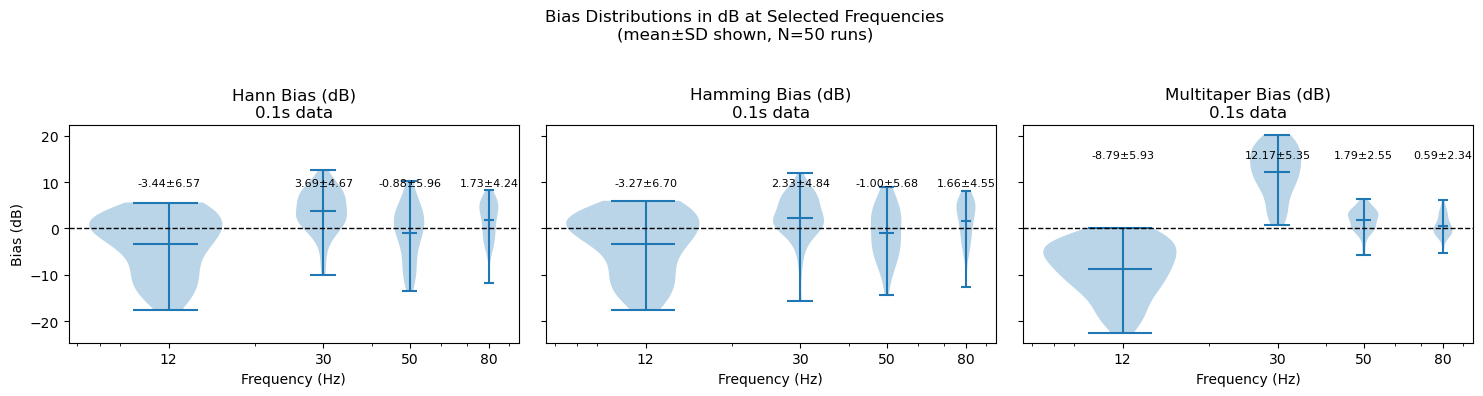

C:\Users\alice\AppData\Local\Temp\ipykernel_29100\966066182.py:34: RuntimeWarning: divide by zero encountered in log10
  P_th_db = 10 * np.log10(P_th)


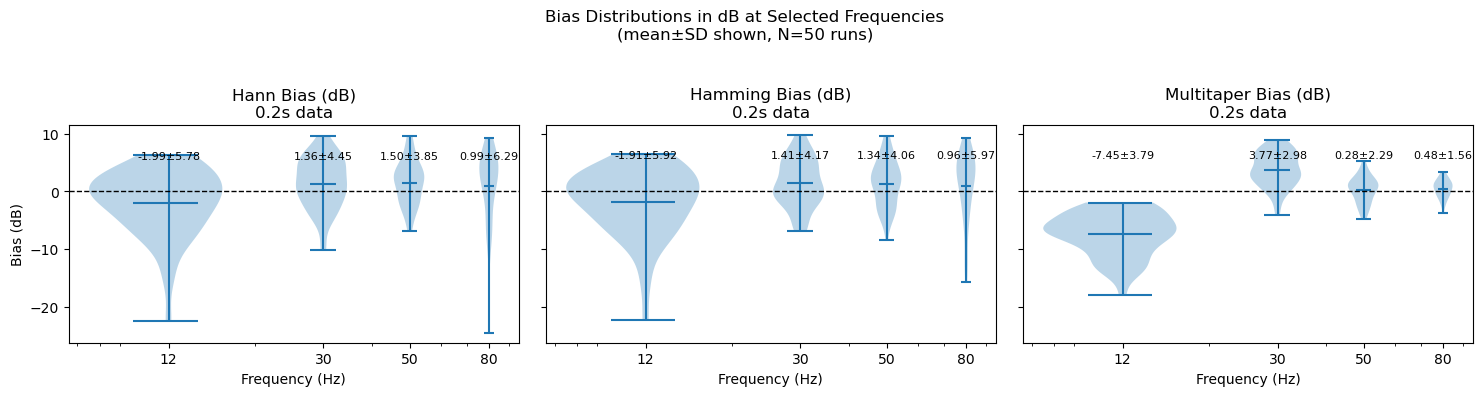

C:\Users\alice\AppData\Local\Temp\ipykernel_29100\966066182.py:34: RuntimeWarning: divide by zero encountered in log10
  P_th_db = 10 * np.log10(P_th)


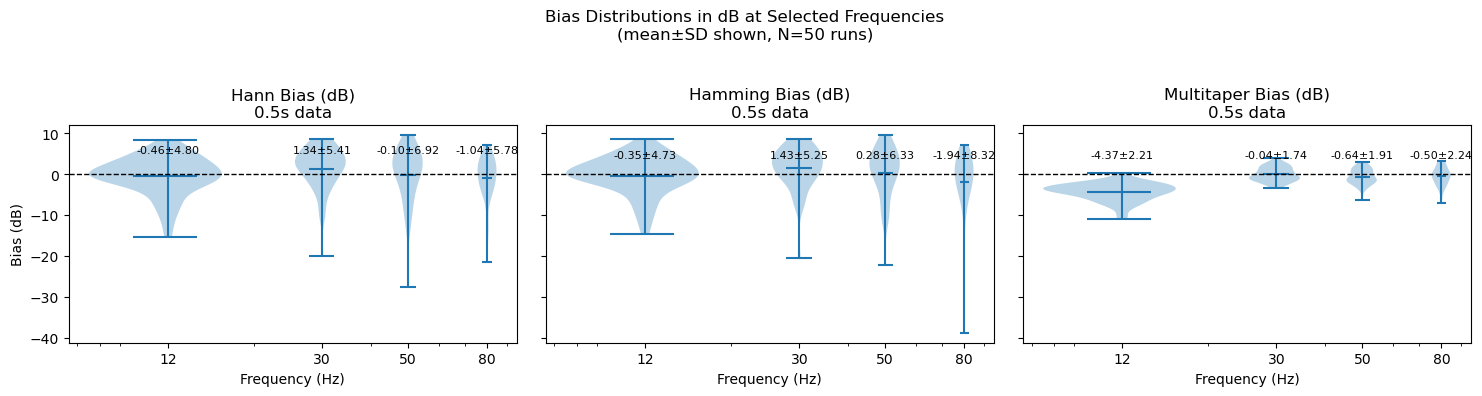

C:\Users\alice\AppData\Local\Temp\ipykernel_29100\966066182.py:34: RuntimeWarning: divide by zero encountered in log10
  P_th_db = 10 * np.log10(P_th)


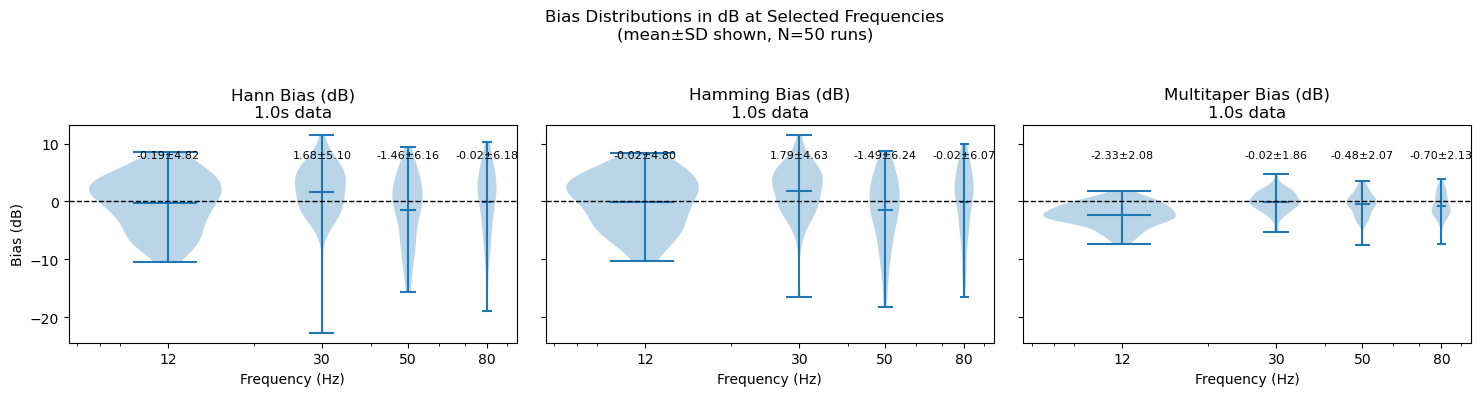

C:\Users\alice\AppData\Local\Temp\ipykernel_29100\966066182.py:34: RuntimeWarning: divide by zero encountered in log10
  P_th_db = 10 * np.log10(P_th)


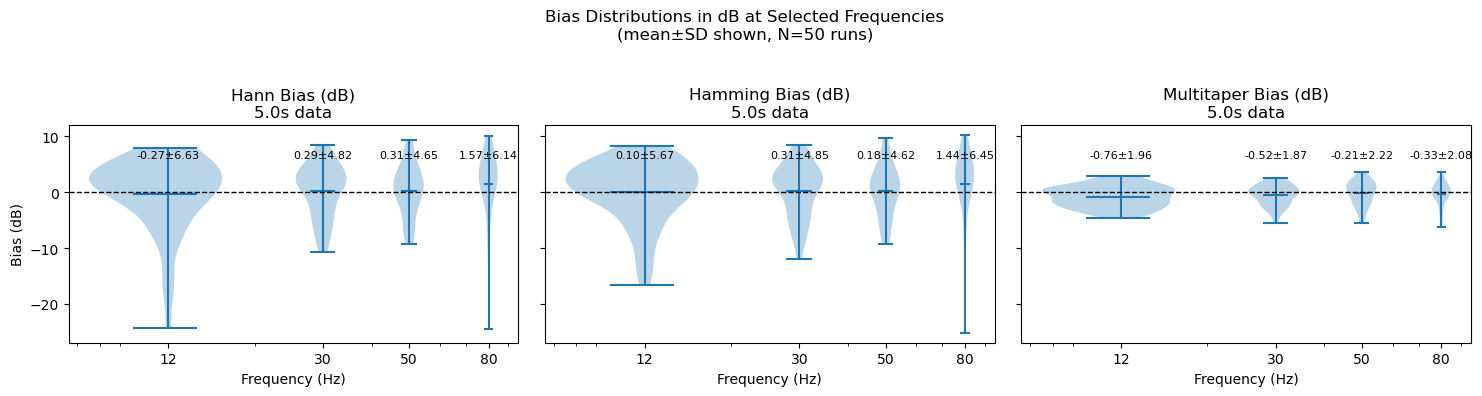

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from spectral_connectivity import Multitaper, Connectivity
from spectral_decomposition import spectrum

# ——— Parameters ——————————————————————————————————————————————————
fs        = 1000.0
durations = [0.05, 0.1, 0.2, 0.5, 1.0, 5.0]   # s
TW        = 3.0
K         = int(2*TW - 1)
n_iter    = 50
seeds     = np.arange(n_iter)
freqs_of_interest = [12, 30, 50, 80]  # Hz

for duration in durations:
    # ——— True PSD in dB ——————————————————————————————————————
    res_th = spectrum(
        sampling_rate      = fs,
        duration           = duration,
        aperiodic_exponent = 2.0,
        aperiodic_offset   = 0.5,
        knee               = 200.0,
        peaks              = [{'freq':12,'amplitude':1.0,'sigma':2.0}],
        average_firing_rate= 0.0,
        random_state       = 0,
        direct_estimate    = False,
        plot               = False
    )
    f_th = res_th.frequency_domain.frequencies
    P_th = res_th.frequency_domain.combined_spectrum
    mask = f_th >= 0
    f_th, P_th = f_th[mask], P_th[mask]
    P_th_db = 10 * np.log10(P_th)

    # ——— empty‐signal freq grids ——————————————————————————————————
    N = int(fs * duration)
    f_hann, _ = periodogram(np.zeros(N), fs=fs, window='hann',   nfft=N, scaling='density')
    f_hamm, _ = periodogram(np.zeros(N), fs=fs, window='hamming', nfft=N, scaling='density')
    f_mt      = Connectivity.from_multitaper(
                   Multitaper(np.zeros(N), sampling_frequency=fs,
                             time_halfbandwidth_product=TW, n_tapers=K)
               ).frequencies

    # ——— allocate storage for bias in dB ————————————————————————
    bias_hann_db = np.zeros((n_iter, len(f_hann)))
    bias_hamm_db = np.zeros_like(bias_hann_db)
    bias_mt_db   = np.zeros((n_iter, len(f_mt)))

    # ——— Monte Carlo draws ————————————————————————————————————
    for i, seed in enumerate(seeds):
        res = spectrum(
            sampling_rate      = fs,
            duration           = duration,
            aperiodic_exponent = 2.0,
            aperiodic_offset   = 0.5,
            knee               = 200.0,
            peaks              = [{'freq':12,'amplitude':1.0,'sigma':2.0}],
            average_firing_rate= 0.0,
            random_state       = int(seed),
            direct_estimate    = True,
        )
        sig = res.time_domain.combined_signal

        # single‐taper
        _, P_h = periodogram(sig,  fs=fs, window='hann',   nfft=len(sig), scaling='density')
        _, P_m = periodogram(sig,  fs=fs, window='hamming', nfft=len(sig), scaling='density')
        P_h_db = 10 * np.log10(P_h)
        P_m_db = 10 * np.log10(P_m)

        # multitaper
        conn     = Connectivity.from_multitaper(
                       Multitaper(sig, sampling_frequency=fs,
                                 time_halfbandwidth_product=TW, n_tapers=K)
                   )
        fcur, P_t = conn.frequencies, conn.power().squeeze()
        P_t_db    = 10 * np.log10(P_t)

        # interpolate true dB‐PSD
        P_th_hann_db = np.interp(f_hann, f_th, P_th_db)
        bias_hann_db[i,:] = P_h_db - P_th_hann_db

        P_th_hamm_db = np.interp(f_hamm, f_th, P_th_db)
        bias_hamm_db[i,:] = P_m_db - P_th_hamm_db

        P_th_mt_db  = np.interp(fcur, f_th, P_th_db)
        bias_mt_db[i,:]    = P_t_db - P_th_mt_db

    # ——— find indices of interest ————————————————————————————————
    idx_hann = [np.argmin(np.abs(f_hann - f)) for f in freqs_of_interest]
    idx_hamm = [np.argmin(np.abs(f_hamm - f)) for f in freqs_of_interest]
    idx_mt   = [np.argmin(np.abs(f_mt   - f)) for f in freqs_of_interest]

    # ——— plot violins with medians, means, and annotate mean±SD ——————
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    for ax, data_db, fgrid, idxs, title in zip(
        axes,
        [bias_hann_db, bias_hamm_db, bias_mt_db],
        [f_hann,       f_hamm,       f_mt],
        [idx_hann,     idx_hamm,     idx_mt],
        ['Hann',       'Hamming',    'Multitaper']
    ):
        vp = ax.violinplot(
            [data_db[:, j] for j in idxs],
            positions=freqs_of_interest,
            widths=0.5*(freqs_of_interest[1]-freqs_of_interest[0]),
            showmeans=True
        )
        ax.set_xscale('log')
        ax.set_xticks(freqs_of_interest)
        ax.set_xticklabels([str(f) for f in freqs_of_interest])
        ax.axhline(0, linestyle='--', color='k', linewidth=1)
        ax.set_title(f'{title} Bias (dB)\n{duration}s data')
        ax.set_xlabel('Frequency (Hz)')

        # annotate mean±SD above each violin
        means = [data_db[:, j].mean() for j in idxs]
        stds  = [data_db[:, j].std()  for j in idxs]
        ylim = ax.get_ylim()
        y_text = ylim[1] - 0.15*(ylim[1]-ylim[0])
        for x, m, s in zip(freqs_of_interest, means, stds):
            ax.text(x, y_text, f'{m:.2f}±{s:.2f}', ha='center', fontsize=8)

    axes[0].set_ylabel('Bias (dB)')
    plt.suptitle(f'Bias Distributions in dB at Selected Frequencies\n'
                 f'(mean±SD shown, N={n_iter} runs)')
    plt.tight_layout(rect=[0,0,1,0.94])
    plt.show()


## Practically how terrible they are relative to the theoretical solution

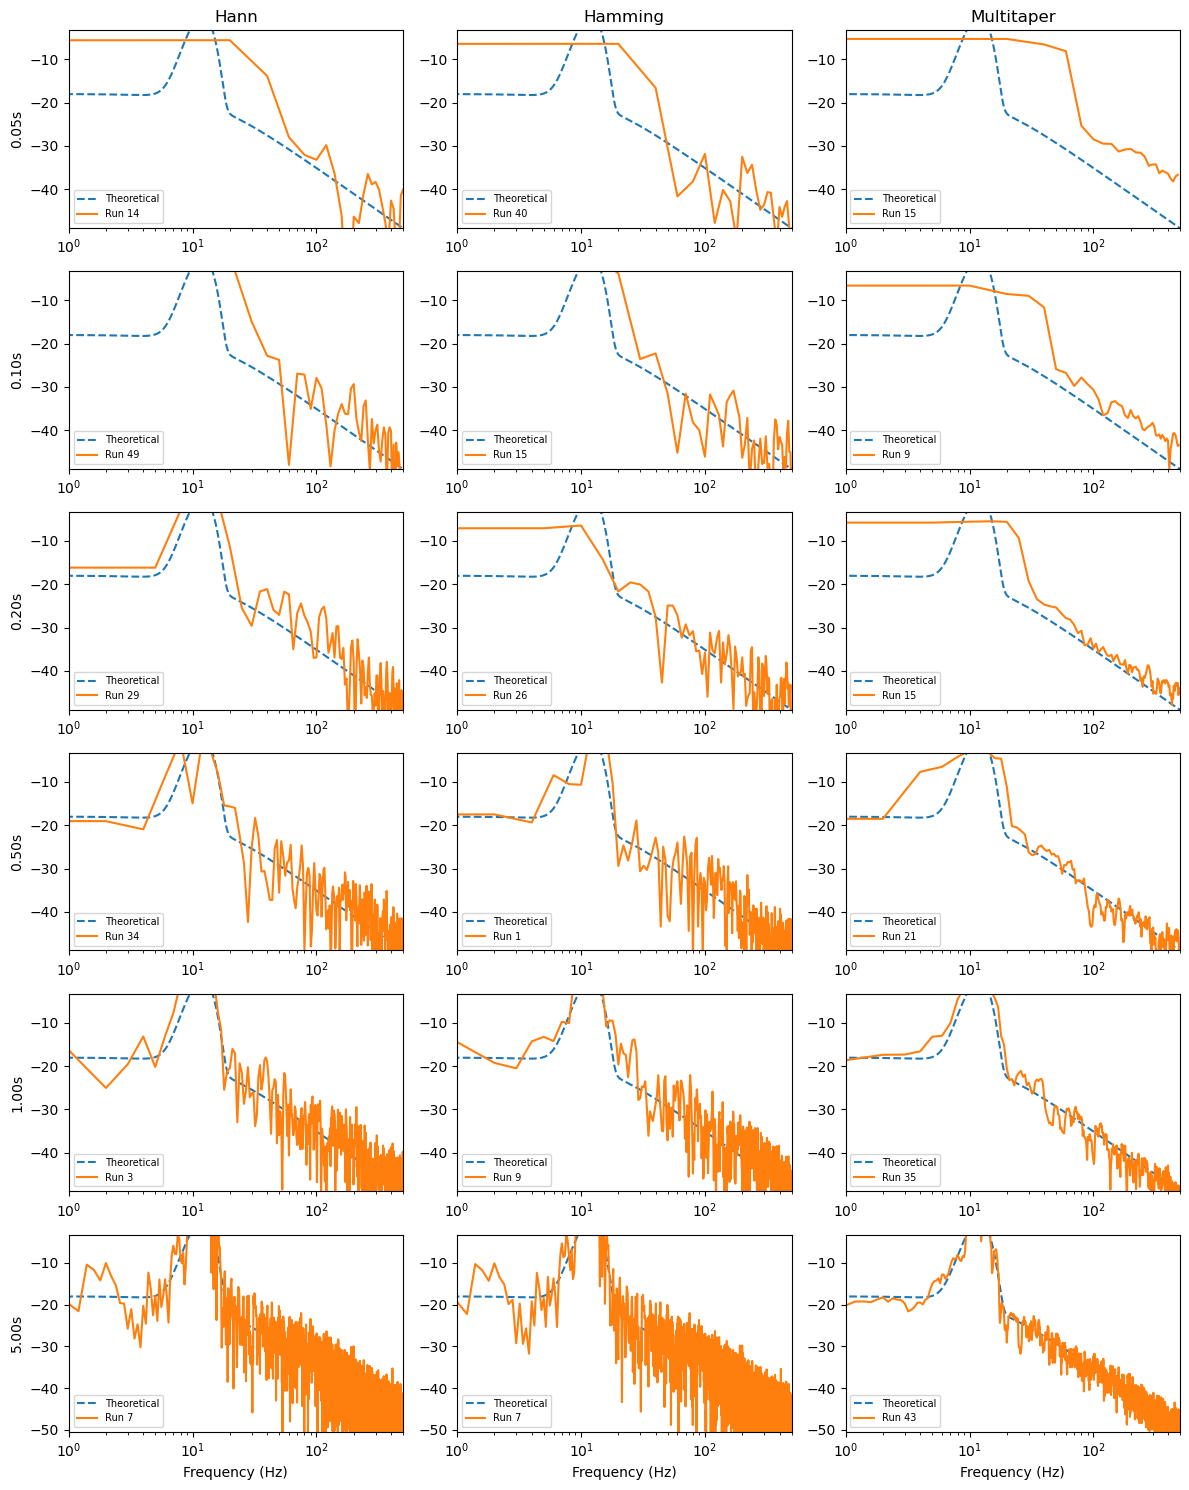

In [6]:
# ——— Parameters ——————————————————————————————————————————————————
fs        = 1000.0
durations = [0.05, 0.1, 0.2, 0.5, 1.0, 5.0]   # five rows
TW        = 3.0
K         = int(2*TW - 1)
n_iter    = 50
seeds     = np.arange(n_iter)

eps = 1e-12   # floor to avoid log10(0)

# Prep figure
fig, axes = plt.subplots(len(durations), 3,
                         figsize=(12, 2.5 * len(durations)),
                         sharex=False, sharey=False)

for row, duration in enumerate(durations):
    # 1) True PSD
    res_th = spectrum(
        sampling_rate      = fs,
        duration           = duration,
        aperiodic_exponent = 2.0,
        aperiodic_offset   = 0.5,
        knee               = 200.0,
        peaks              = [{'freq':12,'amplitude':1.0,'sigma':2.0}],
        average_firing_rate= 0.0,
        random_state       = 0,
        direct_estimate    = False,
        plot               = False
    )
    f_th = res_th.frequency_domain.frequencies
    P_th = res_th.frequency_domain.combined_spectrum
    mask = f_th >= 0
    f_th, P_th = f_th[mask], P_th[mask]
    P_th_db = 10*np.log10(np.maximum(P_th, eps))

    # 2) Empty‐signal freq grids
    N = int(fs*duration)
    f_hann, _ = periodogram(np.zeros(N), fs, 'hann', nfft=N, scaling='density')
    f_hamm, _ = periodogram(np.zeros(N), fs, 'hamming', nfft=N, scaling='density')
    f_mt      = Connectivity.from_multitaper(
                   Multitaper(np.zeros(N), sampling_frequency=fs,
                             time_halfbandwidth_product=TW, n_tapers=K)
               ).frequencies

    # 3) Storage
    PSD_hann_db = np.zeros((n_iter, len(f_hann)))
    PSD_hamm_db = np.zeros((n_iter, len(f_hamm)))
    PSD_mt_db   = np.zeros((n_iter, len(f_mt)))
    bias_hann   = np.zeros_like(PSD_hann_db)
    bias_hamm   = np.zeros_like(PSD_hamm_db)
    bias_mt     = np.zeros_like(PSD_mt_db)

    # 4) Monte Carlo
    for i, seed in enumerate(seeds):
        res = spectrum(
            sampling_rate      = fs,
            duration           = duration,
            aperiodic_exponent = 2.0,
            aperiodic_offset   = 0.5,
            knee               = 200.0,
            peaks              = [{'freq':12,'amplitude':1.0,'sigma':2.0}],
            average_firing_rate= 0.0,
            random_state       = int(seed),
            direct_estimate    = True,
        )
        sig = res.time_domain.combined_signal

        # Hann/Hamming
        _, P_h = periodogram(sig, fs, 'hann',   nfft=len(sig), scaling='density')
        _, P_m = periodogram(sig, fs, 'hamming', nfft=len(sig), scaling='density')
        P_h_db  = 10*np.log10(np.maximum(P_h, eps))
        P_m_db  = 10*np.log10(np.maximum(P_m, eps))
        PSD_hann_db[i,:] = P_h_db
        PSD_hamm_db[i,:] = P_m_db

        # Multitaper
        conn    = Connectivity.from_multitaper(
                      Multitaper(sig, sampling_frequency=fs,
                                time_halfbandwidth_product=TW, n_tapers=K)
                  )
        fcur, P_t = conn.frequencies, conn.power().squeeze()
        P_t_db    = 10*np.log10(np.maximum(P_t, eps))
        PSD_mt_db[i,:] = P_t_db

        # abs‐bias
        bias_hann[i,:] = np.abs(P_h_db   - np.interp(f_hann, f_th, P_th_db))
        bias_hamm[i,:] = np.abs(P_m_db   - np.interp(f_hamm, f_th, P_th_db))
        bias_mt[i,:]   = np.abs(P_t_db   - np.interp(fcur,  f_th, P_th_db))

    # 5) Pick worst runs
    run_hann = np.argmax(bias_hann.mean(axis=1))
    run_hamm = np.argmax(bias_hamm.mean(axis=1))
    run_mt   = np.argmax(bias_mt.mean(axis=1))

    picks = [
        (f_hann, PSD_hann_db[run_hann], 'Hann', run_hann),
        (f_hamm, PSD_hamm_db[run_hamm], 'Hamming', run_hamm),
        (f_mt,   PSD_mt_db[run_mt],     'Multitaper', run_mt),
    ]

    # 6) Plot
    # determine finite y‐limits across theoretical + all three runs
    all_vals = np.concatenate([
        P_th_db,
        PSD_hann_db[run_hann],
        PSD_hamm_db[run_hamm],
        PSD_mt_db[run_mt],
    ])
    y0, y1 = np.nanpercentile(all_vals, [1, 99])

    for col, (fgrid, psd_db, title, runidx) in enumerate(picks):
        ax = axes[row, col]
        ax.semilogx(f_th, P_th_db, '--', label='Theoretical')
        ax.semilogx(fgrid, psd_db, '-', label=f'Run {runidx}')
        ax.set_xlim([1, fs/2])
        ax.set_ylim([y0, y1])
        if row == 0:        ax.set_title(title)
        if col == 0:        ax.set_ylabel(f"{duration:.2f}s")
        if row == len(durations)-1:
            ax.set_xlabel('Frequency (Hz)')
        ax.legend(fontsize=7, loc='lower left')

plt.tight_layout()
plt.show()


## Real data

In [7]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import mne

# 1) Load .mat and extract channel 'O1'
mat = scipy.io.loadmat('/content/subject_02.mat')
for key, val in mat.items():
    if isinstance(val, np.ndarray) and val.ndim == 2 and val.shape[1] in (18, 19):
        data = val
        break
sfreq = 512.0
# 'O1' is the 15th EEG column: zero-based index 14 of data[:,1:17]
data_ch = data[:, 1:17][:, 14]

# 2) Parameters
durations = [0.05, 0.1, 0.2, 0.5, 1.0, 5.0]   # window lengths in seconds
subset_seconds = None  # 20.0 or set to None for full data
alpha = 0.1
TW = 1.0              # time-halfbandwidth product
K = int(2*TW - 1)     # number of DPSS tapers

# Determine how much data to use
n_total = len(data_ch)
total_time = n_total / sfreq
if subset_seconds is not None:
    n_total = min(n_total, int(subset_seconds * sfreq))
    total_time = n_total / sfreq
data_ch = data_ch[:n_total]

# 3) Setup plotting grid
fig, axes = plt.subplots(len(durations), 3,
                         figsize=(12, 2.5 * len(durations)),
                         sharex=True, sharey=True)

# Colormap for segment start times
cmap = plt.cm.viridis
norm = plt.Normalize(0, total_time)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# 4) Loop over window durations
for row, dur in enumerate(durations):
    nperseg = int(dur * sfreq)
    n_segs = n_total // nperseg
    ax_h, ax_m, ax_mt = axes[row]

    for seg_idx in range(n_segs):
        start_time = seg_idx * dur
        seg = data_ch[seg_idx*nperseg:(seg_idx+1)*nperseg]
        color = cmap(norm(start_time))

        # Hann periodogram
        f_h, P_h = periodogram(seg, fs=sfreq, window='hann',
                                nfft=nperseg, scaling='density')
        ax_h.loglog(f_h, P_h, color=color, alpha=alpha)

        # Hamming periodogram
        f_m, P_m = periodogram(seg, fs=sfreq, window='hamming',
                                nfft=nperseg, scaling='density')
        ax_m.loglog(f_m, P_m, color=color, alpha=alpha)

        # Multitaper via DPSS
        mt = Multitaper(time_series=seg,
                        sampling_frequency=sfreq,
                        time_halfbandwidth_product=TW,
                        n_tapers=K)
        conn = Connectivity.from_multitaper(mt)
        f_mt = conn.frequencies
        P_mt = conn.power().squeeze()
        ax_mt.loglog(f_mt, P_mt, color=color, alpha=alpha)

    # aesthetics
    for ax in (ax_h, ax_m, ax_mt):
        ax.set_xlim(1, sfreq/2)
        ax.set_ylim(1e-8, None)
        ax.grid(True, ls=':', lw=0.5)
    ax_h.set_ylabel(f"{dur}s")

# Column titles and x-labels
for ax, title in zip(axes[0], ['Hann', 'Hamming', 'Multitaper']):
    ax.set_title(title)
for ax in axes[-1]:
    ax.set_xlabel('Frequency (Hz)')

fig.subplots_adjust(right=0.88)

# make a new axes for the colorbar
cax = fig.add_axes([1.02,  # x-start (102% of figure width)
                    0.0,  # y-start (0% up from bottom)
                    0.02,  # width (2% of figure width)
                    1.0])  # height (100% of figure height)

# draw the colorbar into that axes
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Segment start time (s)')

plt.suptitle(f"Windowed PSDs for 'O1' colored by time (subset: {subset_seconds}s)", y=1.02)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'mne'